In [1]:
## check slides for proof
soft_thresholding <- function(x,a){
    ## This could be done more efficiently using vector multiplication
    ## See the forumula in slides
    ##  sign(x)*pmax(abs(x) - a, 0)
    result <- numeric(length(x))
    result[which(x > a)] <- x[which(x > a)] - a
    result[which(x < -a)] <- x[which(x < -a)] + a
    return(result)
}          



In [2]:
lasso_kkt_check <- function(X,y,beta,lambda, tol=1e-3){
    ## check convergence 
    beta <- as.matrix(beta); X <- as.matrix(X)
    ## Assuming no intercepts 
    G <- t(X)%*%(y-X%*%beta)/length(y)
    ix <- which(beta == 0 )
    iy <- which(beta != 0)
    if (any(abs(G[ix]) > (lambda + tol) )) { return(pass=0) }
    if (any(abs( G[iy] - lambda*sign(beta[iy] ) ) > tol)) { return(pass=0) }  
    return(pass=1)
}        

lasso_obj <- function(X, y, beta, lambda) {
    (1/2)*(1/length(y))*norm(y - X%*%beta,"F")^2 + lambda*sum(abs(beta))
}

In [3]:
lasso.cd <- function(X,y,beta,lambda,tol=1e-6,maxiter=1000,quiet=FALSE){
    # note that the LS part  in this function is the one in slides divided by length(y) = n 
    ## Or equivalently  lambda here = n * lambda in class
    beta <- as.matrix(beta); X <- as.matrix(X)
    obj <- numeric(length=(maxiter+1))
    betalist <- list(length=(maxiter+1))
    betalist[[1]] <- beta
    for (j in 1:maxiter){
        for (k in 1:length(beta)){
            r <- y - X[,-k]%*%beta[-k]
            beta[k] <- (1/norm(as.matrix(X[,k]),"F")^2)*soft_thresholding(t(r)%*%X[,k],length(y)*lambda)
        }
        betalist[[(j+1)]] <- beta
        obj[j] <- lasso_obj(X, y, beta, lambda)
        if (norm(betalist[[j]] - beta,"F") < tol) { break }
    } 
    check <- lasso_kkt_check(X,y,beta,lambda) 
    if (quiet==FALSE){
        if (check==1) {
            cat(noquote("Minimum obtained.\n"))
        }
      else { cat(noquote("Minimum not obtained.\n")) } 
    }
    return(list(obj=obj[1:j],beta=beta)) 
}            

# Simulate Data

In [4]:
set.seed(100)
n <- 50
p <- 400
X <- matrix(rnorm(n*p), n, p)
b <- rep(0, 400)
b[301:305] <- c(5:1)*2
y <-  X%*%b + rnorm(n)
ynew <-  X%*%b + rnorm(n)      

In [6]:
library(glmnet) 
system.time( fit <- glmnet(X, y, intercept=F, standardize=F, lambda=1) )

   user  system elapsed 
  0.005   0.000   0.005 

In [7]:
system.time( re <- lasso.cd(X, y, rep(0, 400), 1) ) 

Minimum obtained.


   user  system elapsed 
  1.700   0.449   2.157 

## Comparison

In [8]:
beta_glmnet <- as.numeric(coef(fit)[-1] )

In [9]:
max( abs( beta_glmnet - re$beta )  ) 

[1] 0.001974784

Difference between our algorithm and glmnet is small

In [10]:
lasso_obj( X, y, beta_glmnet, 1 )

[1] 26.01695

In [11]:
lasso_obj( X, y, re$beta, 1 )

[1] 26.01695

The objective function values are almost the same.

In [12]:
lasso_obj( X, y, re$beta, 1 ) - lasso_obj( X, y, beta_glmnet, 1 )

[1] -2.64914e-06

In fact, our solution is better than glmnet.

## Warm start

In [39]:
system.time( re <- lasso.cd(X, y, re$beta, 0.9) ) 

Minimum obtained.


   user  system elapsed 
  1.180   0.259   1.439 

In [40]:
system.time( re <- lasso.cd(X, y, rep(0, 400), 0.9) ) 

Minimum obtained.


   user  system elapsed 
  1.824   0.406   2.230 

Speed-up due to better initialization of $\beta$

# Loss

In [10]:
system.time( re <- lasso.cd(X, y, rep(0, 400), 1) ) 
re$obj

Minimum obtained.


   user  system elapsed 
  1.544   0.359   1.903 

[1] 66.11770 48.94246 40.60772 35.46711 31.84361 29.17541 27.39291 26.45345
 [9] 26.17144 26.07184 26.03739 26.02471 26.01982 26.01792 26.01725 26.01704
[17] 26.01697 26.01695 26.01695 26.01695 26.01695 26.01695 26.01695 26.01695
[25] 26.01695 26.01695 26.01695 26.01695 26.01695 26.01695 26.01695 26.01695
[33] 26.01695

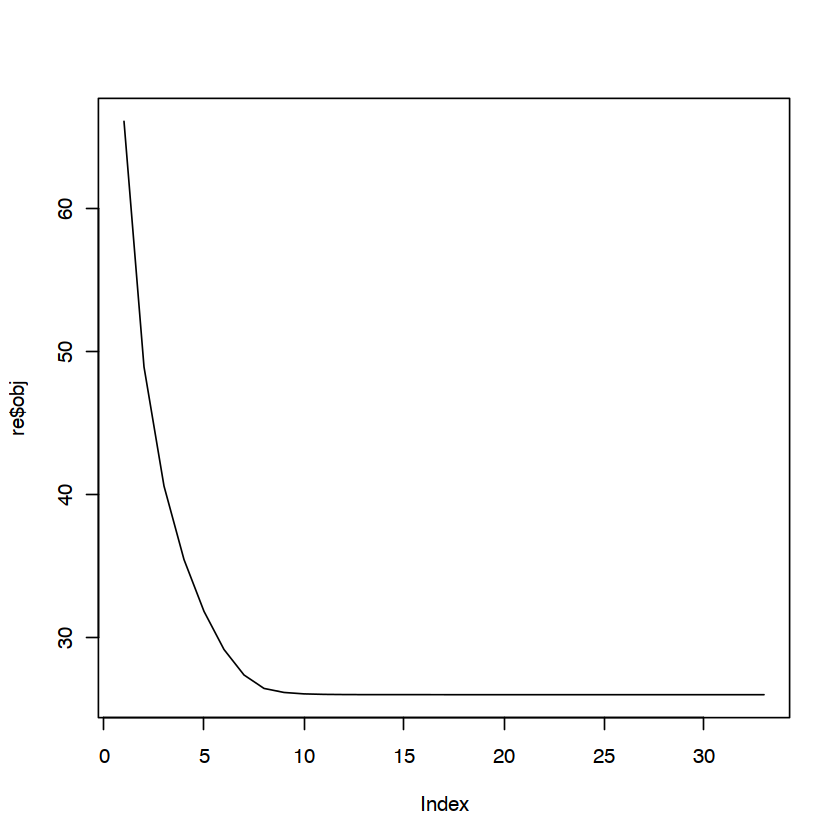

In [12]:
plot(re$obj, type="l")

Objective function decays as expected